# Desafío - Mecanismos de Votación
- Para realizar este desafío debes haber estudiado previamente todo el material disponibilizado correspondiente a la unidad.
- Una vez terminado el desafío, comprime la carpeta que contiene el desarrollo de los requerimientos solicitados y sube el .zip en el LMS.
- Desarrollo desafío:
    - El desafío se debe desarrollar de manera Individual.
    - Para la realización del desafío necesitarás apoyarte del archivo Apoyo Desafío - Mecanismos de Votación.

## Requerimientos
Para esta actividad desarrollaremos un ensamble heterogéneo que prediga la popularidad o impopularidad de contenido en línea de un sitio web. El archivo csv tiene un total de 39.797 registros, donde cada uno representa características del artículo publicado en el sitio web.

Cada registro tiene un total de 61 atributos que miden características del texto, cantidad de imágenes, keywords, etc. Los artículos provienen de la publicación K. Fernandes, P. Vinagre and P. Cortez. A Proactive Intelligent Decision Support System for Predicting the Popularity of Online News. Proceedings of the 17th EPIA 2015 - Portuguese Conference on Artificial Intelligence, September, Coimbra, Portugal. Los artículos registrados son de <a href="https://www.mashable.com/">esta página web</a>.

Más información sobre los atributos se puede encontrar en el archivo `OnlineNewsPopularity.names`.

### Ejercicio 1 - Preparación del Ambiente de Trabajo
- A continuación se le presenta un código que agrupa las variables por grupos. Cada uno de éstos hace referencia a alguna característica de los registros en la base de datos. Genere una análisis descriptivo de cada uno de los atributos. Puede utilizar la función `grid_plot_batch` que se encuentra en el archivo `helpers.py`.
```python
# las etiquetas de las columnas presentan un espacio extra, con ésto lo podemos eliminar
df.columns = [i.replace(' ', '') for i in df.columns]
# eliminamos el string de url que no sirve para el análisis
df = df.loc[:, 'n_tokens_title':'shares']
# generamos el conjunto de variables
qnty = df.filter(regex='^n_', axis=1)
channel = df.filter(regex='^data_', axis=1)
days = df.filter(regex=re.compile("weekday|weekend"), axis=1)
sentiments = df.filter(regex=re.compile("negative|positive|subjectivity"), axis=1)
lda = df.filter(regex='^LDA_\d', axis=1)
keywords = df.filter(regex='^kw_', axis=1)
```

- Describa el comportamiento de las variables.
- Dada la naturaleza de los atributos, es probable que algunas mediciones estén correlacionadas entre sí. Para ello, genere un diagnóstico previo de multicolinealidad utilizando la función `identify_high_correlations` que se encuentra en el archivo `helpers.py`. Para todos aquellos atributos que tengan una correlación de .8 o más, reporte sus nombres.
- Antes de generar los conjuntos de entrenamiento y validación, pre procese los datos con los siguientes pasos:
    - Recodifique la variable shares en una variable binaria que identifique como 1 todos los registros con más de 1400 "compartir" y 0 de lo contrario. Para evitar multicolinealidad, elimine la variable `shares` posteriormente.
    - Elimine todas las variables que presentaban una correlación mayor a .8 (una del par). Este paso es para evitar la multicolinealidad de los atributos.
    - Genere un análisis de Componentes Principales para extraer las principales 30 dimensiones. Guarde estas dimensiones en un nuevo objeto.

In [1]:
# Utilice esta celda para importar los módulos necesarios y el set de datos que está en OnlineNewsPopularity/OnlineNewsPopularity.csv

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
from helpers import grid_plot_batch, grid_plot_batch, identify_high_correlations, plot_classification_report
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier

df = pd.read_csv('OnlineNewsPopularity/OnlineNewsPopularity.csv')
df

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.100000,0.70,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.033333,0.70,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.100000,1.00,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.136364,0.80,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.033333,1.00,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39639,http://mashable.com/2014/12/27/samsung-app-aut...,8.0,11.0,346.0,0.529052,1.0,0.684783,9.0,7.0,1.0,...,0.100000,0.75,-0.260000,-0.500,-0.125000,0.100000,0.000000,0.400000,0.000000,1800
39640,http://mashable.com/2014/12/27/seth-rogen-jame...,8.0,12.0,328.0,0.696296,1.0,0.885057,9.0,7.0,3.0,...,0.136364,0.70,-0.211111,-0.400,-0.100000,0.300000,1.000000,0.200000,1.000000,1900
39641,http://mashable.com/2014/12/27/son-pays-off-mo...,8.0,10.0,442.0,0.516355,1.0,0.644128,24.0,1.0,12.0,...,0.136364,0.50,-0.356439,-0.800,-0.166667,0.454545,0.136364,0.045455,0.136364,1900
39642,http://mashable.com/2014/12/27/ukraine-blasts/,8.0,6.0,682.0,0.539493,1.0,0.692661,10.0,1.0,1.0,...,0.062500,0.50,-0.205246,-0.500,-0.012500,0.000000,0.000000,0.500000,0.000000,1100


In [2]:
# Utilice esta celda para aplicar el procesamiento indicado en el enunciado (implemente el mismo código)

# las etiquetas de las columnas presentan un espacio extra, con ésto lo podemos eliminar
df.columns = [i.replace(' ', '') for i in df.columns]
# eliminamos el string de url que no sirve para el análisis
df = df.loc[:, 'n_tokens_title':'shares']
# generamos el conjunto de variables
qnty = df.filter(regex='^n_', axis=1)
channel = df.filter(regex='^data_', axis=1)
days = df.filter(regex=re.compile("weekday|weekend"), axis=1)
sentiments = df.filter(regex=re.compile("negative|positive|subjectivity"), axis=1)
lda = df.filter(regex='^LDA_\d', axis=1)
keywords = df.filter(regex='^kw_', axis=1)

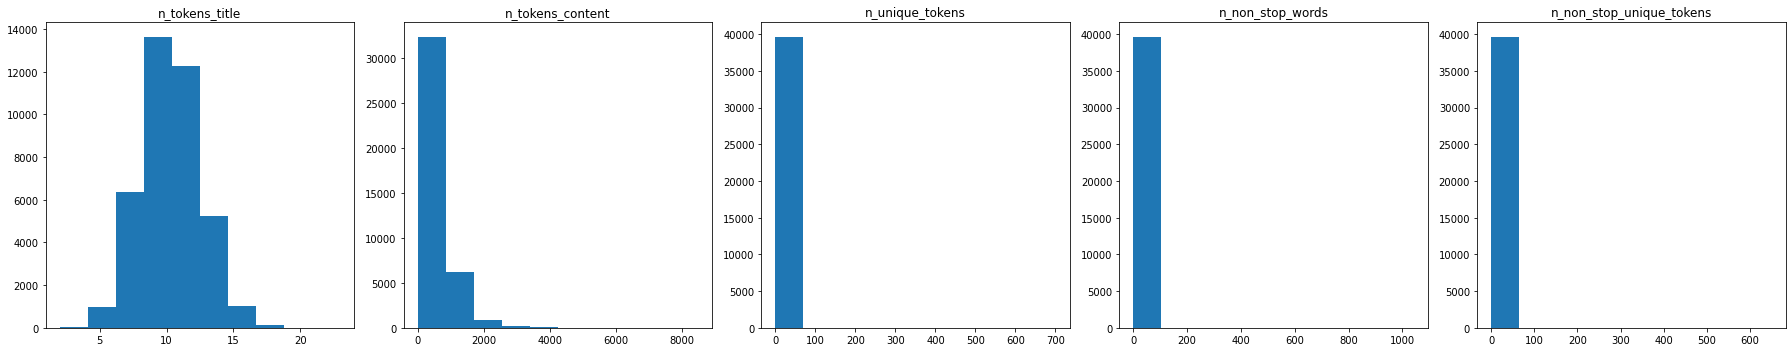

In [3]:
# Utilice esta celda para realizar los gráficos llamando a la función helpers.grid_plot_batch para qnty
#    - Se recomienda setear antes plt.figure(figsize=(10, 5))
#    - Los argumentos de la función en este caso son qnty, 3, plt.hist

plt.figure(figsize=(25, 5))
grid_plot_batch(qnty, 5, plt.hist)

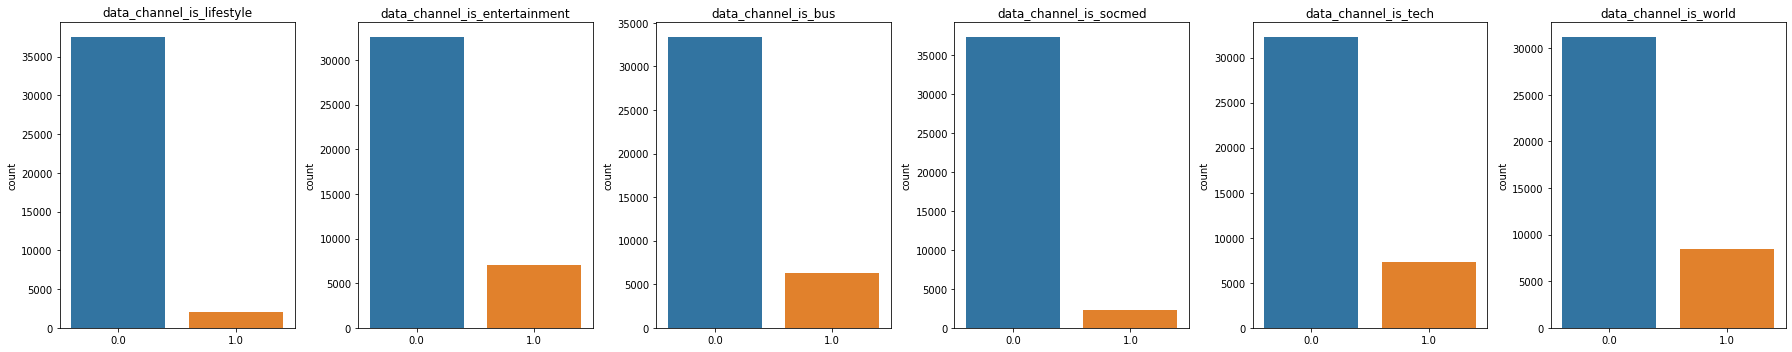

In [4]:
# Utilice esta celda para realizar los gráficos llamando a la función grid_plot_batch para channel.
# Como tercer argumento utilice sns.countplot
plt.figure(figsize=(25, 5))
grid_plot_batch(channel, 6, sns.countplot)

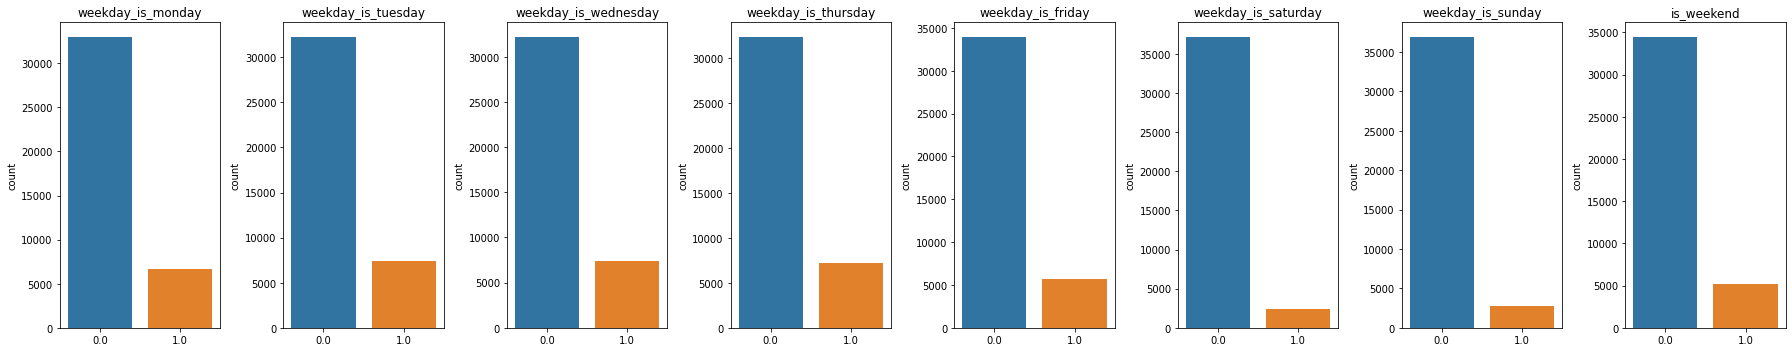

In [5]:
# Utilice esta celda para realizar los gráficos llamando a la función grid_plot_batch para days (variable categórica).

plt.figure(figsize=(25, 5))
grid_plot_batch(days, 8, sns.countplot)

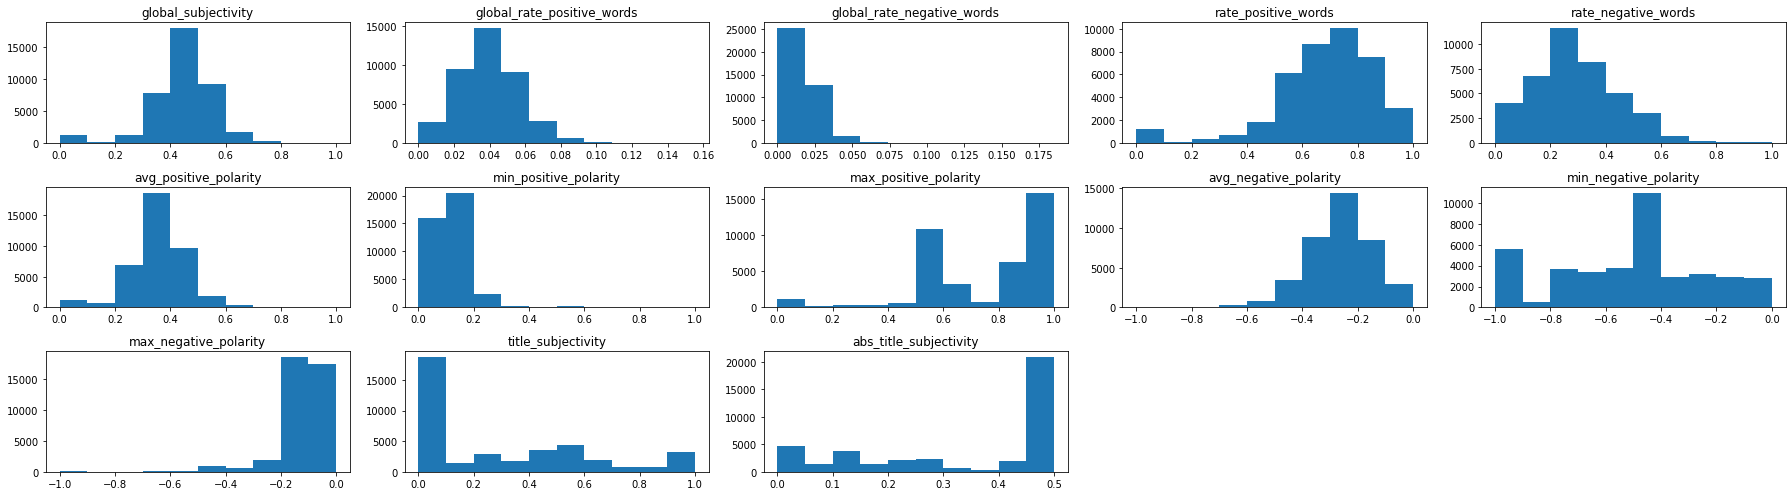

In [6]:
# Utilice esta celda para realizar los gráficos llamando a la función grid_plot_batch para sentiments (variable continua).

plt.figure(figsize=(25, 7))
grid_plot_batch(sentiments, 5, plt.hist)

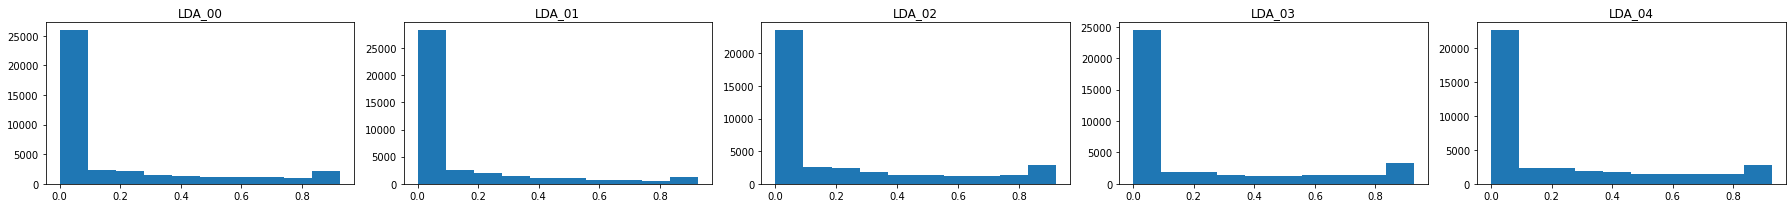

In [7]:
# Utilice esta celda para realizar los gráficos llamando a la función grid_plot_batch para lda (variable continua).

plt.figure(figsize=(25, 3))
grid_plot_batch(lda, 5, plt.hist)

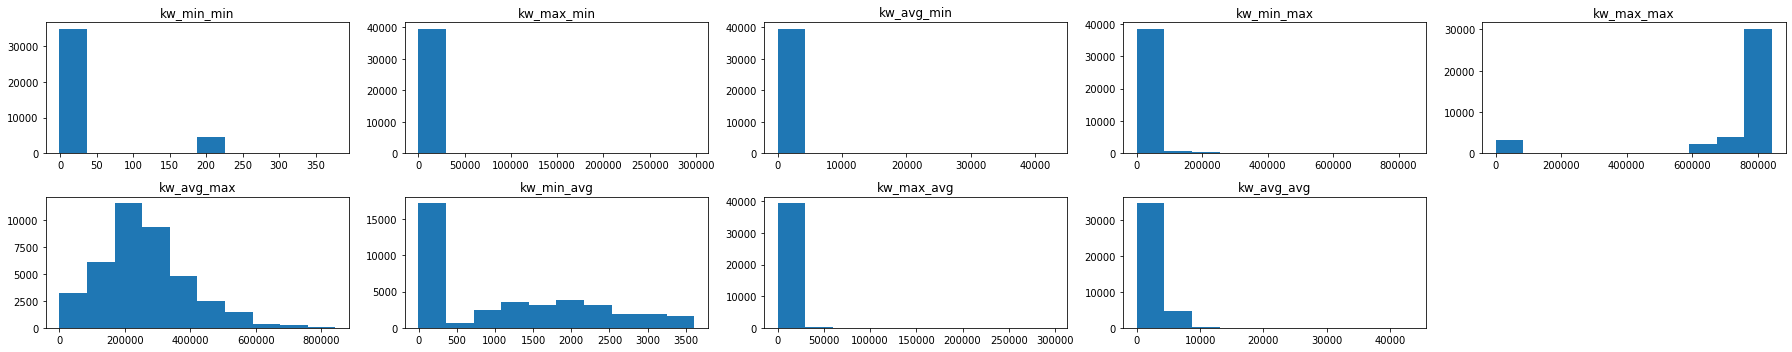

In [8]:
# Utilice esta celda para realizar los gráficos llamando a la función grid_plot_batch para keywords (variable continua).

plt.figure(figsize=(25, 5))
grid_plot_batch(keywords, 5, plt.hist)

In [9]:
# Utilice esta celda para identificar correlaciones altas con helpers.identify_high_correlations, asignando su retorno a df_correlaciones
#  Se modificó la función para que solo entregue correlaciones mayores a 0.8

df_correlaciones = identify_high_correlations(df)
df_correlaciones

,variable,var2,value
179,n_non_stop_words,n_unique_tokens,0.999572
238,n_non_stop_unique_tokens,n_unique_tokens,0.999852
239,n_non_stop_unique_tokens,n_non_stop_words,0.999532
1139,kw_avg_min,kw_max_min,0.940529
1256,kw_max_max,kw_min_min,-0.857226
1499,kw_avg_avg,kw_max_avg,0.811864
1678,self_reference_avg_sharess,self_reference_min_shares,0.818907
1679,self_reference_avg_sharess,self_reference_max_shares,0.853480
2317,LDA_02,data_channel_is_world,0.836618


In [10]:
# Utilice esta celda para generar la variable class en base a shares; shares > 1400 -> 1, de lo contrario 0. Muestre las frecuencias de class.

df['class'] = np.where(df['shares']>1400,1,0)
df['class'].value_counts()

0    20082
1    19562
Name: class, dtype: int64

In [11]:
# Utilice esta celda para eliminar las variables altamente correlacionadas y la variable shares
#   Para identificar las variables con alta correlacion a eliminar utilice:
#      list(set(df_correlaciones["variable"]) - set(df_correlaciones["var2"]))
#   Guarde en una nueva variable X_mat el dataframe con las columnas eliminadas
#   Almacene en una variable y el vector objetivo class, que también se debe eliminar de X_mat

column_drop = list(set(df_correlaciones["variable"]) - set(df_correlaciones["var2"]))
column_drop.append('n_unique_tokens') #Agregamos esta variable ya que la lista de arriba no entrega la tupla mas correlacionada
X_mat = df.drop(columns=column_drop)

# Separamos data para el split
y = X_mat['class']
X_mat = X_mat.drop(columns=['shares','class']) 

In [12]:
# Utiliza esta celda para generar la división de muestras a partir de "X_mat" y de "y"

X_train, X_test, y_train, y_test = train_test_split(X_mat, y, test_size=0.3, random_state=13)

- A continuación se detalla los pasos para implementar PCA "a mano". Alternativamente, si lo desea puede hacer una implementación con Pipeline, que se tendría que hacer en los ejercicios siguientes, para cada modelo / ensamble.

In [13]:
# Utiliza esta celda para estandarizar X_train (primero entrenando, y en otro paso transformando), ya que PCA funciona sobre datos estandarizados
#    NOTA: Las variables binarias no debiesen incluirse en la estandarización ni en el PCA
#    Considerando que es un ejercicio, en este caso las puede conservar incluyéndolas en la estandarización y en PCA
# Almacene los datos estandarizados en X_train_std

# Cambiamos el tipo de las variables categóricas tanto para train como test
column_category = list(days.columns) + list(channel.columns)
X_train[column_category] = X_train[column_category].astype(int)
X_test[column_category] = X_test[column_category].astype(int)

# Definimos las columnas a estandarizar
column_std = X_train.select_dtypes(float).columns

# Instanciamos y fiteamos la estandarizacion
scaler = StandardScaler().fit(X_train[column_std])

# Transformamos tanto el dataset de entrenamiento
X_train[column_std] = scaler.transform(X_train[column_std])

In [14]:
# Utiliza esta celda para entrenar (fit) PCA con 30 componentes sobre X_train_std, y almacenar transformación en X_train_pca

pca = PCA(n_components=30, random_state=13).fit(X_train[column_std])

# Aplicamos PCA
train_pca = pca.transform(X_train[column_std])
X_train_pca = pd.DataFrame(train_pca, columns = [f'PCA_{i}' for i in range(1,31)])

# Agregamos las columnas categoricas
X_train.reset_index(inplace=True)
X_train_pca[column_category] = X_train[column_category]

In [15]:
# Utiliza esta celda para generar X_test_pca a partir del escalador previamente entrenado, y luego a partir del pca previamente entrenado

# Estandarizamos 
X_test[column_std] = scaler.transform(X_test[column_std])

# Aplicamos PCA
test_pca = pca.transform(X_test[column_std])
X_test_pca = pd.DataFrame(test_pca, columns = [f'PCA_{i}' for i in range(1,31)])

# Agregamos las columnas categoricas
X_test.reset_index(inplace=True)
X_test_pca[column_category] = X_test[column_category]

### Ejercicio 2 - Evaluación de modelos individuales
- A continuación generará una serie de modelos que se incorporarán posteriormente al comité de votación. Para ello, se solicita que:
    - Importe los módulos correctamente.
    - Para cada uno de ellos, genere un reporte en las métricas de desempeño respecto a Precision, Recall, F1. Puede hacer uso de la función `plot_classification_report` disponible en el archivo `helpers.py`.
    ```python
    plt.figure(figsize=(10, 10))
    for index, value in enumerate(estimators):
        plt.subplot(len(estimators), 1, index + 1)
        plt.title(value[0])
        class_pred = value[1].fit(X_train_pca, y_train).predict(X_test_pca)
        helpers.lot_classification_report(y_test, class_pred)
        plt.axvline(.5, label='.5 Boundary', linestyle='--')
        plt.xlim((0.1, 1.0))
        if (index + 1) % 2 == 0:
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    ```
    - Comente el desempeño general de cada uno.
<br />
<br />


- La lista de modelos es la siguiente. Cabe destacar que la mayoría de éstos corresponden a implementaciones vanilla, salvo que se indique lo contrario:
    - Regresión Logística.
    - K Nearest Neighbors con `n_neighbors=5`.
    ```python
    from sklearn.neighbors import KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors=3)
    ```
    - Árbol de Clasificación con un `max_depth=1`.
    - Árbol de Clasificación con un `max_depth=4`.

In [16]:
# Utilice esta celda para generar la variable estimators que almacene la lista con tuplas (etiqueta, modelo) para los modelos solicitados

estimators = [
    ('Regresión Logística', LogisticRegression(random_state=13)),
    ('K Nearest Neighbors', KNeighborsClassifier(n_neighbors=3)),
    ('Arbol de Clasificación, max_depth=1', DecisionTreeClassifier(max_depth=1, random_state=13)),
    ('Arbol de Clasificación, max_depth=4', DecisionTreeClassifier(max_depth=4, random_state=13)),                 
]

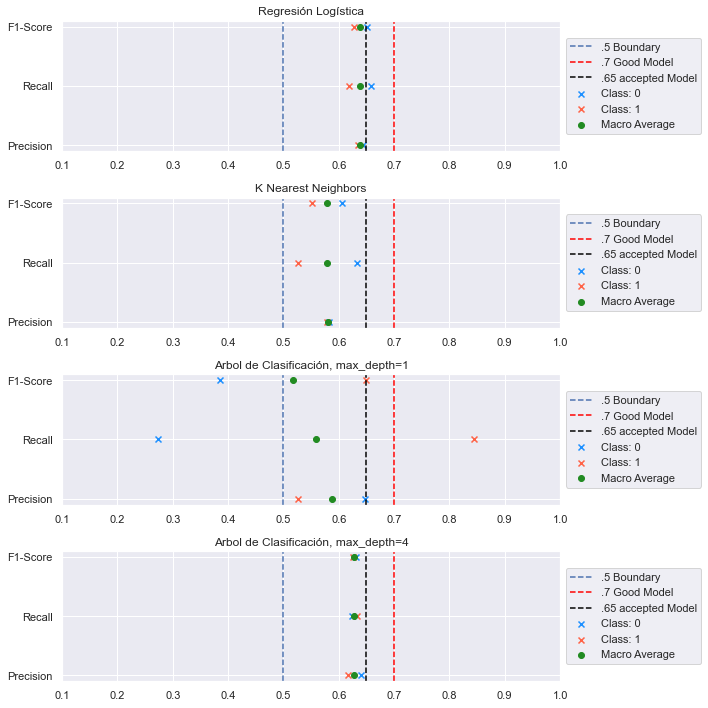

In [17]:
# Utilice esta celda para ejecutar el código del enunciado que hace el llamado a plot_classification_report
sns.set_theme()
#sns.set_style("white")

plt.figure(figsize=(10, 10))
for index, value in enumerate(estimators):
    plt.subplot(len(estimators), 1, index + 1)
    plt.title(value[0])
    class_pred = value[1].fit(X_train_pca, y_train).predict(X_test_pca)
    plot_classification_report(y_test, class_pred)
    plt.axvline(.5, label='.5 Boundary', linestyle='--')
    plt.axvline(.7, label='.7 Good Model', linestyle='--', color='Red')
    plt.axvline(.65, label='.65 accepted Model', linestyle='--', color='black')
    plt.xlim((0.1, 1.0))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

**Comentarios** a simple vista, podemos apreciar que tanto el modelo logistico como el arbol de clasicionacion con max_depth=4 son los mejores modelos con métricas muy similares.

### Ejercicio 3 - Entrenamiento de Comité
- Entrene el comité de clasificadores sin modificar el esquema de votación.
- Reporte el desempeño a nivel de cada clase para cada métrica.

In [18]:
# Utilice esta celda para entrenar VotingClassifier, y generar predicciones sobre X_test_pca

vot_hard = VotingClassifier(estimators = estimators).fit(X_train_pca, y_train)

y_pred = vot_hard.predict(X_test_pca)

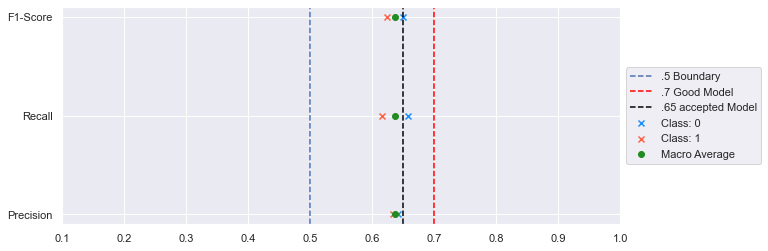

In [19]:
# Utilice esta celda para reportar desempeño utilizando helpers.plot_classification_report

plt.figure(figsize=(10, 4))
plot_classification_report(y_test, y_pred)
plt.axvline(.5, label='.5 Boundary', linestyle='--')
plt.axvline(.7, label='.7 Good Model', linestyle='--', color='Red')
plt.axvline(.65, label='.65 accepted Model', linestyle='--', color='black')
plt.xlim((0.1, 1.0))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

**Comentarios** basicamente, obtenemos el mismo resultado que con el modelo logistico.

### Ejercicio 4 - Calibración de Comité con Ponderadores
- En base al comportamiento de los clasificadores individuales del ensamble, proponga dos esquemas de ponderación para mejorar el desempeño del modelo.
- Reporte el desempeño del mejor ensamble heterogéneo

In [20]:
# Utilice esta celda para definir los esquemas de pesos

weighting_schemes = {
    'weight_scheme_1': [.40, .05, .05, .50],
    'weight_scheme_2': [.10, .60, .20, .10]
}

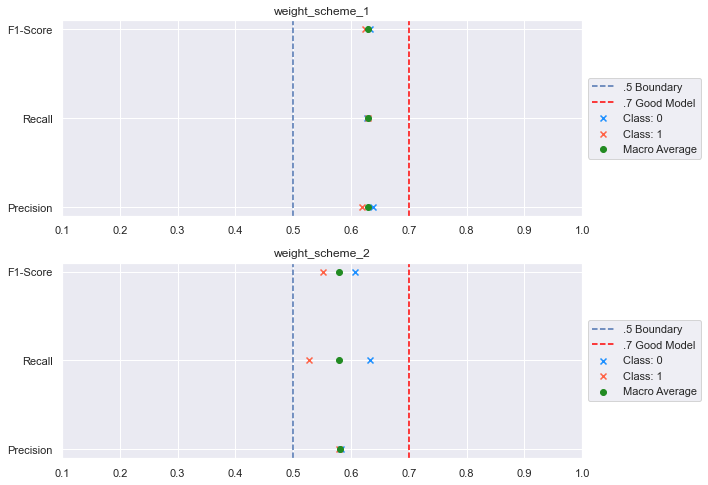

In [21]:
# Utilice esta celda para entrenar los nuevos clasificadores y graficar su desempeño. Sugerencia: Use un for y la funcion plot_classification_report

plt.figure(figsize=(10, 10))
for index, value in enumerate(weighting_schemes.items()):
    plt.subplot(3, 1, index + 1)
    plt.title(value[0])
    class_pred = VotingClassifier(estimators, weights = value[1]).fit(X_train_pca, y_train).predict(X_test_pca)
    plot_classification_report(y_test, class_pred)
    plt.axvline(.5, label='.5 Boundary', linestyle='--')
    plt.axvline(.7, label='.7 Good Model', linestyle='--', color='Red')
    plt.xlim((0.1, 1.0))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

**Comentarios** 

claramente, se aprecia como dando distintos pesos a modelos, las predicciones del modelo de votación cambian bastante (esto ya que en la primera iteracion, los pesos eran mayores en los mejores modelos, y en la segunda iteracion, se le dio mayor peso a los modelos con peores métricas)

Aunque se le dió mas pesos a los mejores modelos, las métricas son practgicamente las mismas que para el modelo logístico